In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil 
%matplotlib inline

from keras.preprocessing.image import load_img, img_to_array
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from keras.models import load_model
from datetime import *





Using TensorFlow backend.


In [0]:
def leerParametrosFichero(ruta):
  diccionarioParametros = {}
  
  # Abre archivo en modo lectura
  with open(ruta,'r') as archivo:
    # inicia bucle infinito para leer línea a línea.
    while True: 
      linea = archivo.readline()  # lee línea.
      if not linea: 
          break  # Si no hay más se rompe bucle.
      linea = linea.rstrip() #Quita caracteres vacios y \n a la derecha.
      
      key, value = linea.strip().split('=') #dividimos la linea mediante el signo = . izquierda la clave y derecha valor
      key = key.strip() #quitamos espacios en blancos de la parte izquierda
      key = key.strip("'") #quitamos comillas simples de la parte izquierda
      
      value = value.strip() # #quitamos espacios en blancos de la parte derecha
      value = value.strip("'") # quitamos comillas simples de la parte derecha
      
      diccionarioParametros[key] = value
  archivo.close  # Cierra archivo
  
  return diccionarioParametros

In [0]:
def predecirImagen(fileImg,fecha,red,fIniSin,fFinSin,fIniSiem,fFinSiem,fIniCre,fFinCre,altura,anchura,diccionarioFases):
  
  print("------- Prediciendo la imágen:",fileImg,"... -------")
  formatFecha = "%d-%m-%Y"
  dateFecha = datetime.strptime(fecha, formatFecha)
  fecha = dateFecha.replace(year=2013) #Convertimos la fecha para que todas esten el mismo año para compararse.

  
  print("Fecha comprobada:",dateFecha)
  print("Fecha Inicio Sin Siembra:",fIniSin)
  print("Fecha Fin Sin Siembra:",fFinSin)
  print("Fecha Inicio Siembra:",fIniSiem)
  print("Fecha Fin Siembra:",fIniSin)
  print("Fecha Inicio Crecimiento:",fIniCre)
  print("Fecha Fin Crecimiento:",fFinCre)
 

  #Cargamos la imagen para mostrarla.
  imagenCargada = load_img(fileImg, target_size=(altura, anchura))
  fig = plt.figure(figsize=(5, 5))
  fig.set_facecolor('white')
  plt.imshow(imagenCargada,'BrBG') # Typically the color map for NDVI maps are the Red to Yellow to Green
  
  plt.title('Imagen: ' +fileImg )
  plt.show()
  

  #Ahora utilizamos la imagen cargada para hacer su prediccion.
  imagenCargada = img_to_array(imagenCargada)
  imagenCargada = np.expand_dims(imagenCargada, axis=0)
 
  arrayPrediccion = red.predict(imagenCargada) #metodo que predice la imagen con la red cargada.
  resultado = arrayPrediccion[0]
  respuestaFasePrediccion = np.argmax(resultado)
  
  
  #Transformamos el resultado de la respuesta de la prediccion a una cadena para poder comparar.
  if respuestaFasePrediccion == 0:
    print("Predicción de la red : Crecimiento")
    respuestaML = 'Crecimiento' 
  elif respuestaFasePrediccion == 1:
    print("Predicción de la red : Siembra")
    respuestaML = 'Siembra'
  elif respuestaFasePrediccion == 2:
    print("Predicción de la red : sinSiembra")
    respuestaML = 'sinSiembra'
    
  
  #Comprobamos ahora a que fase cultivo deberia pertencer por las fechas en la que se encuentra.
  if fecha >= fIniSin and fecha <= fFinSin:
    respuestaFaseFecha = 'sinSiembra'
  elif fecha >= fIniSiem and fecha < fFinSiem:
    respuestaFaseFecha = 'Siembra'
  elif fecha >= fIniCre and fecha < fFinCre:
    respuestaFaseFecha = 'Crecimiento' 
  else:
    respuestaFaseFecha = 'No corresponde a la temporada de este cultivo'
  print('Resultado por fecha:',respuestaFaseFecha)
  

    
  if respuestaML == respuestaFaseFecha:
      resultadoPrediccionImagen = True
      if diccionarioFases[respuestaML] == False:
        diccionarioFases[respuestaML] = True
  else:
      resultadoPrediccionImagen = False
  
  
  return resultadoPrediccionImagen, diccionarioFases

In [0]:
def obtenerResultadosImagenes(diccionarioIMG,red,dateFISS,dateFFSS,dateFIS,dateFFS,dateFIC,dateFFC,altura,anchura):
  listaResultados = []
  diccionarioFases = {'Crecimiento': False, 'Siembra':False, 'sinSiembra': False }
  for imagen in diccionarioIMG.keys():
    tuplaImg = eval(diccionarioIMG[imagen])
    rutaImg = tuplaImg[0]
    fechaImg = tuplaImg[1]
    resultadoPrediccion, diccionarioFases = predecirImagen(rutaImg,fechaImg,red,dateFISS,dateFFSS,dateFIS,dateFFS,dateFIC,dateFFC,altura,anchura,diccionarioFases)
    listaResultados.append(resultadoPrediccion) 
  return listaResultados,diccionarioFases

In [0]:
def comprobarResultados(listaResul,nomCultivo,dicFases):
  numeroCorrectas = 0
  nummeroFases = 0
  numeroResultados = len(listaResul)
  porcentajeAceptacion = 90.0
  
  
  for fase in dicFases.keys():
    if dicFases[fase] == True:
      nummeroFases = nummeroFases + 1
   
  
  if numeroResultados >= 3 and nummeroFases == 3:
    for resultado in listaResul:
      if resultado == True:
        numeroCorrectas = numeroCorrectas +1
      else:
        break
    porcentajeObtenido = numeroCorrectas/numeroResultados * 100
    
    
    if porcentajeObtenido >= porcentajeAceptacion:
      print("El porcentaje de que la parcela sea " +nomCultivo +"es: ",porcentajeObtenido)
      print("La parcela introducida es ",nomCultivo)
    else:
      print("Lo siento,la parcela introducida no es",nomCultivo)
      print("El porcentaje de que sea",nomCultivo," es:",porcentajeObtenido)
  else:
      if(numeroResultados >= 3):
        print("No se puede comprobar,porque el número de fases de cultivo distintas deber ser 3 y solo existen:",nummeroFases) 
      else:
        print("No se puede comprobar,porque el número de resultado debe ser mayor o igual a 3 y solo hay:",numeroResultados) 
  

In [0]:
def procesoComprobacionImagenes(parametros):
  
  print("------- Leyendo los parametros... -------")  
  print(parametros)
  
  enFormatoZIP = eval(parametros['enFormatoZIP'])
  
  #Nombre de la ruta en la que se encuentran los pesos y el modelo.
  rutaModeloYPesos = parametros['rutaModeloYPesos']
  nombreModelo = parametros['nombreModelo']
  nombrePesos = parametros['nombrePesos']
  
  
  #Obtenemos el perdiodo de siembra del cultivo.
  formatoFecha = "%d-%m-%Y"
    
  fechaInicioSinSiembra = parametros['fechaInicioSinSiembra']
  dateFechaInicioSinSiembra = datetime.strptime(fechaInicioSinSiembra, formatoFecha)
  #Convertimos al año 2013 por ejemplo, para que podamos comparar ya que solo nos interesan los dias y meses para las cosechas.
  dateFechaInicioSinSiembra = dateFechaInicioSinSiembra.replace(year=2013) 

  
  fechaFinSinSiembra = parametros['fechaFinSinSiembra']
  dateFechaFinSinSiembra = datetime.strptime(fechaFinSinSiembra, formatoFecha)
  dateFechaFinSinSiembra = dateFechaFinSinSiembra.replace(year=2013) 

  
  fechaInicioSiembra = parametros['fechaInicioSiembra']
  dateFechaInicioSiembra = datetime.strptime(fechaInicioSiembra, formatoFecha)
  dateFechaInicioSiembra = dateFechaInicioSiembra.replace(year=2013) 

  fechaFinSiembra = parametros['fechaFinSiembra']
  dateFechaFinSiembra = datetime.strptime(fechaFinSiembra, formatoFecha)
  dateFechaFinSiembra = dateFechaFinSiembra.replace(year=2013) 

  
  fechaInicioCrecimiento = parametros['fechaInicioCrecimiento']
  dateFechaInicioCrecimiento = datetime.strptime(fechaInicioCrecimiento, formatoFecha)
  dateFechaInicioCrecimiento = dateFechaInicioCrecimiento.replace(year=2013) 

  fechaFinCrecimiento = parametros['fechaFinCrecimiento']
  dateFechaFinCrecimiento = datetime.strptime(fechaFinCrecimiento, formatoFecha)
  dateFechaFinCrecimiento = dateFechaFinCrecimiento.replace(year=2013) 

  
  #Direccion donde se encuentra el fichero con las imagenes para comprobar.
  rutaFicheroImagenesComprobar = parametros['rutaFicheroImagenesComprobar']
  
  #Dimensiones de las imagenes que vamos a cargar.
  alturaImagen = int(parametros['alturaImagen'])
  anchuraImagen = int(parametros['anchuraImagen'])
  
  #Nombre de cultivo que queremos comprobar. (sirve para que muestre si es este de tipo o no)
  nombreCultivo = parametros['nombreCultivo']
  
  try: # comprueba si exista ya el directorio, sino lo creará mediante descompresion 
    os.stat(rutaModeloYPesos) 
    print("Ya existe el directorio")
    print("------- Cargando la red y los pesos... -------")  
    modelo = rutaModeloYPesos +'/' + nombreModelo
    print(modelo)
    pesos_modelo = rutaModeloYPesos +'/' + nombrePesos
    print(pesos_modelo)
    
  except:
    if (enFormatoZIP): #Si la ruta indicada en el fichero es en formato .zip
      rutaZip = parametros['rutaZip']
      if ".zip" not in rutaModeloYPesos:  
        rutaZip = rutaModeloYPesos+'.zip'
        print('------- Descomprimiendo el archivo',rutaZip,'... -------')  
        shutil.unpack_archive(rutaZip,extract_dir= rutaModeloYPesos)
      else:
        print('------- Descomprimiendo el archivo',rutaZip,'... -------') 
        shutil.unpack_archive(rutaZip,extract_dir= rutaModeloYPesos)
    
      print("------- Cargando la red y los pesos... -------")  
      modelo = rutaModeloYPesos +'/' + nombreModelo
      print(modelo)
      pesos_modelo = rutaModeloYPesos +'/' + nombrePesos
      print(pesos_modelo)
    

  diccionarioIMG = leerParametrosFichero(rutaFicheroImagenesComprobar)
  
  with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
    redConvolucionaCargada = load_model(modelo)
  redConvolucionaCargada.load_weights(pesos_modelo)
  
  print("------- Obteniendo los resultados de las imágenes... -------")  
  listaResultados,diccionarioFases = obtenerResultadosImagenes(diccionarioIMG,redConvolucionaCargada,dateFechaInicioSinSiembra,dateFechaFinSinSiembra,dateFechaInicioSiembra,dateFechaFinSiembra,dateFechaInicioCrecimiento,dateFechaFinCrecimiento,alturaImagen,anchuraImagen)
                                            
  print("------- Comprobando los resultados de las imágenes... -------")  
  comprobarResultados(listaResultados,nombreCultivo,diccionarioFases)
  print("------- Fin  del programa -------")  
  

------- Leyendo los parametros... -------
{'enFormatoZIP': 'True', 'rutaZip': '/content/ModeloyPesosTabaco.zip', 'rutaModeloYPesos': '/content/ModeloyPesosTabaco', 'nombreModelo': 'modeloTabaco.h5', 'nombrePesos': 'pesosTabaco.h5', 'fechaInicioSinSiembra': '01-03-2013', 'fechaFinSinSiembra': '11-05-2013', 'fechaInicioSiembra': '12-05-2013', 'fechaFinSiembra': '16-06-2013', 'fechaInicioCrecimiento': '17-06-2013', 'fechaFinCrecimiento': '02-10-2013', 'rutaFicheroImagenesComprobar': '/content/FicheroImagenesParcelasComprobar.txt', 'alturaImagen': '28', 'anchuraImagen': '28', 'nombreCultivo': 'Tabaco'}
------- Descomprimiendo el archivo /content/ModeloyPesosTabaco.zip ... -------
------- Cargando la red y los pesos... -------
/content/ModeloyPesosTabaco/modeloTabaco.h5
/content/ModeloyPesosTabaco/pesosTabaco.h5
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_p

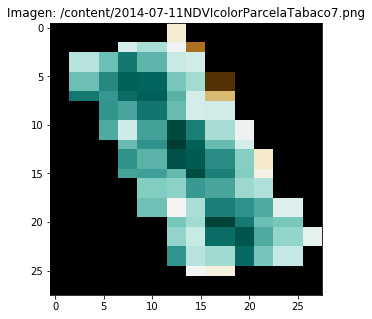

Predicción de la red : Crecimiento
Resultado por fecha: Crecimiento
------- Prediciendo la imágen: /content/2014-08-12NDVIcolorParcelaTabaco7.png ... -------
Fecha comprobada: 2014-08-12 00:00:00
Fecha Inicio Sin Siembra: 2013-03-01 00:00:00
Fecha Fin Sin Siembra: 2013-05-11 00:00:00
Fecha Inicio Siembra: 2013-05-12 00:00:00
Fecha Fin Siembra: 2013-03-01 00:00:00
Fecha Inicio Crecimiento: 2013-06-17 00:00:00
Fecha Fin Crecimiento: 2013-10-02 00:00:00


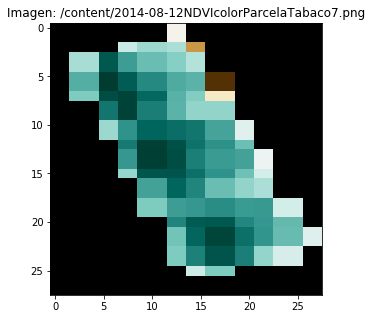

Predicción de la red : Crecimiento
Resultado por fecha: Crecimiento
------- Prediciendo la imágen: /content/2015-05-11NDVIcolorParcelaTabaco7.png ... -------
Fecha comprobada: 2015-05-11 00:00:00
Fecha Inicio Sin Siembra: 2013-03-01 00:00:00
Fecha Fin Sin Siembra: 2013-05-11 00:00:00
Fecha Inicio Siembra: 2013-05-12 00:00:00
Fecha Fin Siembra: 2013-03-01 00:00:00
Fecha Inicio Crecimiento: 2013-06-17 00:00:00
Fecha Fin Crecimiento: 2013-10-02 00:00:00


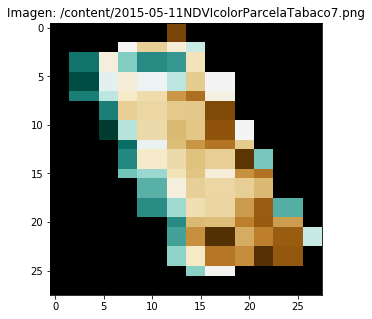

Predicción de la red : sinSiembra
Resultado por fecha: sinSiembra
------- Prediciendo la imágen: /content/2015-05-27NDVIcolorParcelaTabaco7.png ... -------
Fecha comprobada: 2015-05-27 00:00:00
Fecha Inicio Sin Siembra: 2013-03-01 00:00:00
Fecha Fin Sin Siembra: 2013-05-11 00:00:00
Fecha Inicio Siembra: 2013-05-12 00:00:00
Fecha Fin Siembra: 2013-03-01 00:00:00
Fecha Inicio Crecimiento: 2013-06-17 00:00:00
Fecha Fin Crecimiento: 2013-10-02 00:00:00


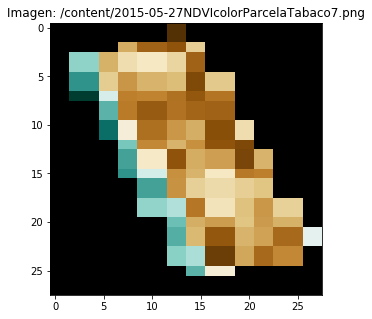

Predicción de la red : Siembra
Resultado por fecha: Siembra
------- Prediciendo la imágen: /content/2017-04-14NDVIcolorParcelaTabaco7.png ... -------
Fecha comprobada: 2017-04-14 00:00:00
Fecha Inicio Sin Siembra: 2013-03-01 00:00:00
Fecha Fin Sin Siembra: 2013-05-11 00:00:00
Fecha Inicio Siembra: 2013-05-12 00:00:00
Fecha Fin Siembra: 2013-03-01 00:00:00
Fecha Inicio Crecimiento: 2013-06-17 00:00:00
Fecha Fin Crecimiento: 2013-10-02 00:00:00


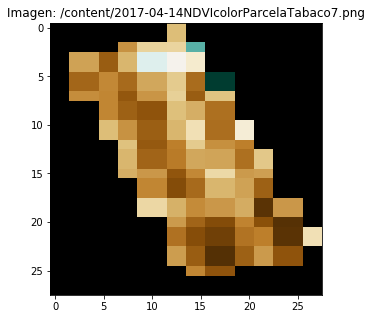

Predicción de la red : sinSiembra
Resultado por fecha: sinSiembra
------- Comprobando los resultados de las imágenes... -------
El porcentaje de que la parcela sea Tabacoes:  100.0
La parcela introducida es  Tabaco
------- Fin  del programa -------


In [7]:
param = leerParametrosFichero('/content/FicheroComprobacionImagenes.txt')
procesoComprobacionImagenes(param)